In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, classification_report
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings("ignore")
data = pd.read_csv("C:/Users/lenovo/Desktop/乳腺癌诊断数据集/wisc_bc_data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [2]:
data.drop("id",axis = 1,inplace=True)
data['diagnosis'] = data['diagnosis'].replace(['M','B'],[1, 0])

In [3]:
columns_to_drop = ["perimeter_mean", "perimeter_se", "perimeter_worst", "area_mean", "area_se", "area_worst", "compactness_mean", "compactness_se", "compactness_worst", "concave points_mean", "concave points_se", "concave points_worst"]
data_new = data.drop(columns_to_drop, axis=1)

In [4]:
data_mean,data_se,data_worst = [],[],[]
for feat in data_new.columns:
    if "mean" in feat:
        data_mean.append(feat)
    elif "se" in feat:
        data_se.append(feat)
    elif "worst" in feat:
        data_worst.append(feat)
print(data_mean)
print(data_se)
print(data_worst)

['radius_mean', 'texture_mean', 'smoothness_mean', 'concavity_mean', 'symmetry_mean', 'fractal_dimension_mean']
['radius_se', 'texture_se', 'smoothness_se', 'concavity_se', 'symmetry_se', 'fractal_dimension_se']
['radius_worst', 'texture_worst', 'smoothness_worst', 'concavity_worst', 'symmetry_worst', 'fractal_dimension_worst']


In [5]:
def standard_scaler(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    scaled_data = (data - mean) / std
    return scaled_data

In [6]:
X = data_new[data_mean]
y = data_new["diagnosis"]
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=0)
train_x = standard_scaler(train_x)
test_x = standard_scaler(test_x)

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='liblinear')
model.fit(train_x, train_y) 
y_predict = model.predict(test_x)

In [8]:
def confusion_matrix(y_true, y_pred):
    tp = tn = fp = fn = 0
    
    for i in range(len(y_true)):
        if y_true[i] == 1 and y_pred[i] == 1:
            tp += 1
        elif y_true[i] == 0 and y_pred[i] == 0:
            tn += 1
        elif y_true[i] == 0 and y_pred[i] == 1:
            fp += 1
        elif y_true[i] == 1 and y_pred[i] == 0:
            fn += 1
    
    return [[tn, fp], [fn, tp]]

In [9]:
confusion_matrix(test_y.values, y_predict)

[[65, 2], [5, 42]]

In [10]:
correct = np.count_nonzero((y_predict == test_y) == True)
print("Accuracy is: %.4f" % (correct/len(test_x)))

Accuracy is: 0.9386


In [11]:
print(classification_report(test_y, y_predict, labels=[0,1], target_names=["良性", "恶性"]))

              precision    recall  f1-score   support

          良性       0.93      0.97      0.95        67
          恶性       0.95      0.89      0.92        47

    accuracy                           0.94       114
   macro avg       0.94      0.93      0.94       114
weighted avg       0.94      0.94      0.94       114



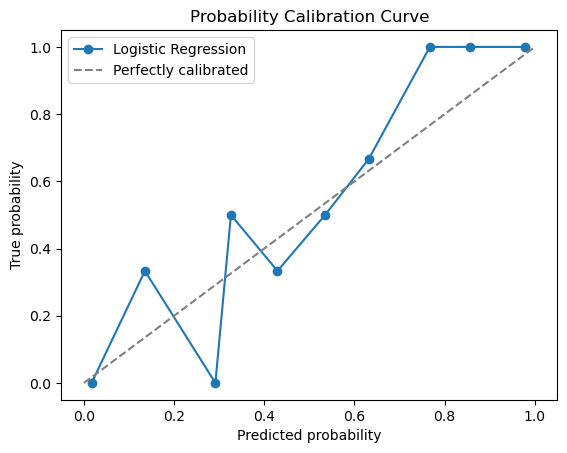

In [12]:
y_prob = model.predict_proba(test_x)[:, 1]
true_prob, pred_prob = calibration_curve(test_y, y_prob, n_bins=10)
plt.plot(pred_prob, true_prob, marker='o', linestyle='-', label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.xlabel('Predicted probability')
plt.ylabel('True probability')
plt.title('Probability Calibration Curve')
plt.legend()
plt.show()

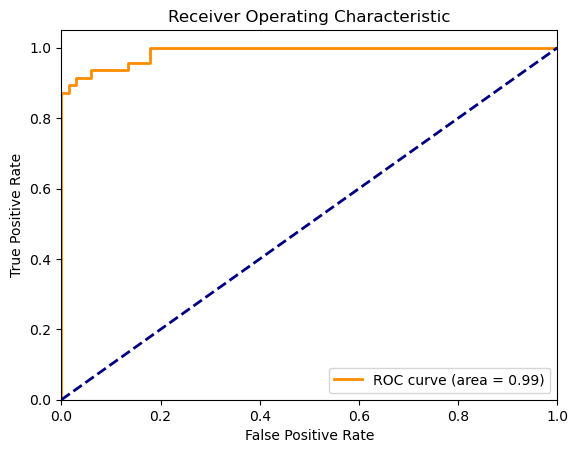

In [13]:
y_pred_proba = model.predict_proba(test_x)[:, 1]
fpr, tpr, thresholds = roc_curve(test_y, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [14]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = None
        self.bias = None
    
    def fit(self, X, y):
        num_samples, num_features = X.shape
        
        # 初始化权重和偏置
        self.weights = np.zeros(num_features)
        self.bias = 0
        
        # 梯度下降训练
        for _ in range(self.num_iterations):
            linear_model = np.dot(X, self.weights) + self.bias
            y_pred = self._sigmoid(linear_model)
            
            # 计算梯度
            dw = (1 / num_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / num_samples) * np.sum(y_pred - y)
            
            # 更新权重和偏置
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
    
    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_pred = self._sigmoid(linear_model)
        y_pred_cls = [1 if pred >= 0.5 else 0 for pred in y_pred]
        return y_pred_cls
    
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

In [15]:
model_2 = LogisticRegression()
model_2.fit(train_x.values, train_y)
y_pred = model_2.predict(test_x)

In [16]:
confusion_matrix(test_y.values, y_pred)

[[67, 0], [6, 41]]

In [17]:
correct = np.count_nonzero((y_pred == test_y) == True)
print((correct/len(test_x)))

0.9473684210526315


In [18]:
print(classification_report(test_y, y_pred, labels=[0,1], target_names=["良性", "恶性"]))

              precision    recall  f1-score   support

          良性       0.92      1.00      0.96        67
          恶性       1.00      0.87      0.93        47

    accuracy                           0.95       114
   macro avg       0.96      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114

